In [196]:
!date

Thu Nov 19 11:33:30 PST 2020


# Sex specific assignments

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata

def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [83]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    #ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


# SmartSeq

In [90]:
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")

In [94]:
isoform.obsm["X_nca_tsne_gene"] = gene.obsm["X_nca_tsne"]

In [104]:
md = pd.read_csv("../../reference/smart-seq_cluster_labels/sample_metadata.csv", index_col = 0)

isoform.obs["sex"] = isoform.obs.cell_id.map(md["gender"])
isoform.obs["batch"] = isoform.obs.cell_id.map(md["batch"])

In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(isoform.obs.groupby("subclass_label")["sex"].value_counts())

subclass_label  sex
Astro           M         6
                F         3
Endo            M         5
                F         2
L2/3 IT         M       381
                F       101
L5 PT           M         9
                F         3
L5 IT           M      1131
                F       430
L5/6 NP         M       126
                F        81
L6 CT           M       611
                F       293
L6 IT           M       252
                F       143
L6 IT Car3      M         3
                F         2
L6b             F       320
                M       250
Lamp5           M       256
                F       104
Low Quality     M        11
                F         1
Pvalb           M       281
                F       240
SMC             M        14
                F         5
Sncg            M        66
                F        11
Sst             M       330
                F        76
VLMC            F         4
                M         2
Vip             M       476


In [97]:
m_mask = isoform.obs.eval("sex == 'M'").values
f_mask = isoform.obs.eval("sex == 'F'").values

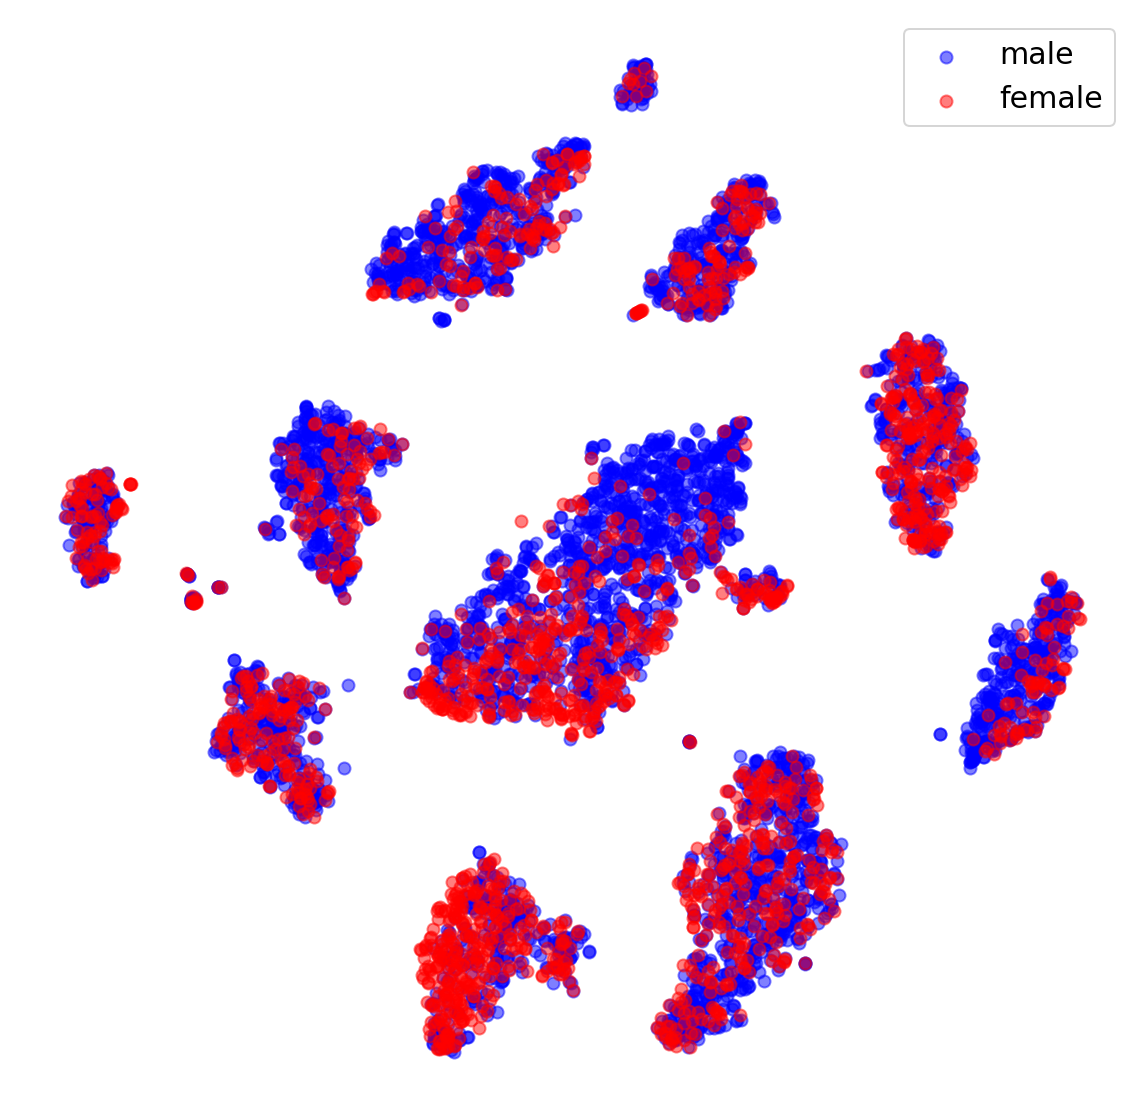

In [100]:
fig, ax = plt.subplots(figsize=(10,10))

X = isoform.obsm["X_nca_tsne_gene"]

x = X[:,0][m_mask]
y = X[:,1][m_mask]
color = "blue"

ax.scatter(x,y,color=color, label="male", alpha=0.5)

x = X[:,0][f_mask]
y = X[:,1][f_mask]
color = "red"

ax.scatter(x,y,color=color, label="female", alpha=0.5)


ax.set_axis_off()
ax.legend()

plt.savefig(trackfig("../../figures/male_female_isoform_tsne_nca.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)

fig.show()

In [108]:
import itertools

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

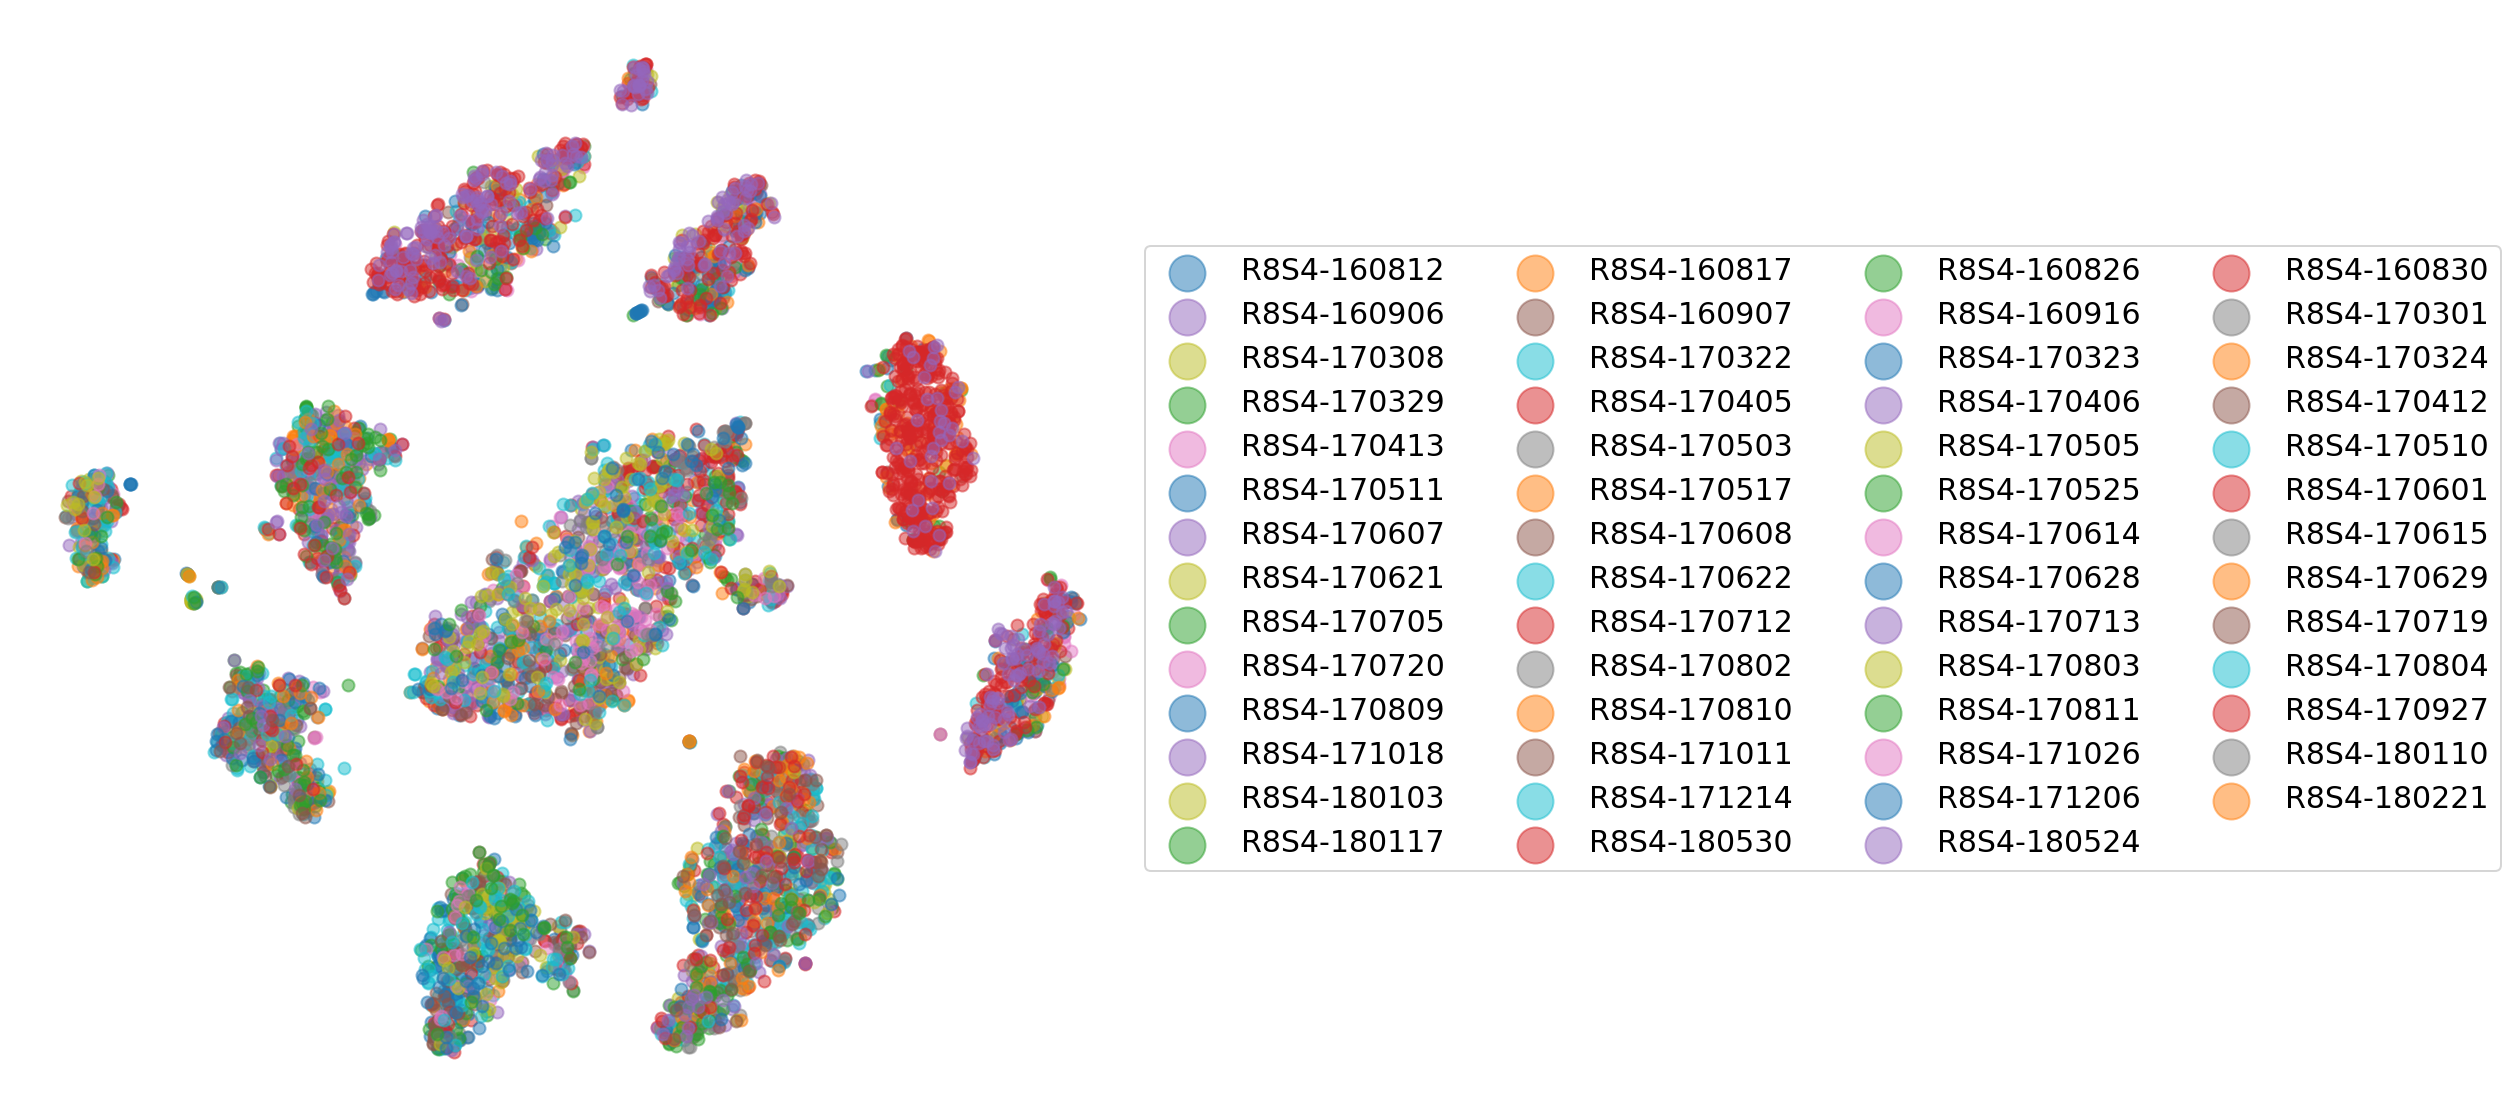

In [117]:
fig, ax = plt.subplots(figsize=(10,10))

X = isoform.obsm["X_nca_tsne_gene"]
for d in isoform.obs["batch"].unique():
    mask = isoform.obs.eval(f"batch == '{d}'").values
    x = X[:,0][mask]
    y = X[:,1][mask]

    ax.scatter(x,y, label=f"{d}", alpha=0.5)

ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
ax.legend(flip(handles, 4), flip(labels, 4), ncol=4, bbox_to_anchor=(1, 0.5), loc="center left", markerscale=3)
#plt.savefig(trackfig("../../figures/sample_merfish_gene_tsne.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)

fig.show()

In [171]:
df = (isoform.obs.groupby("batch")["sex"].value_counts()/isoform.obs.groupby("batch")["sex"].count()).unstack().fillna(0)
df = df.sort_values("M")

In [172]:
labels = df.index.values
categories = df.columns.values
data = df.values.T.copy()

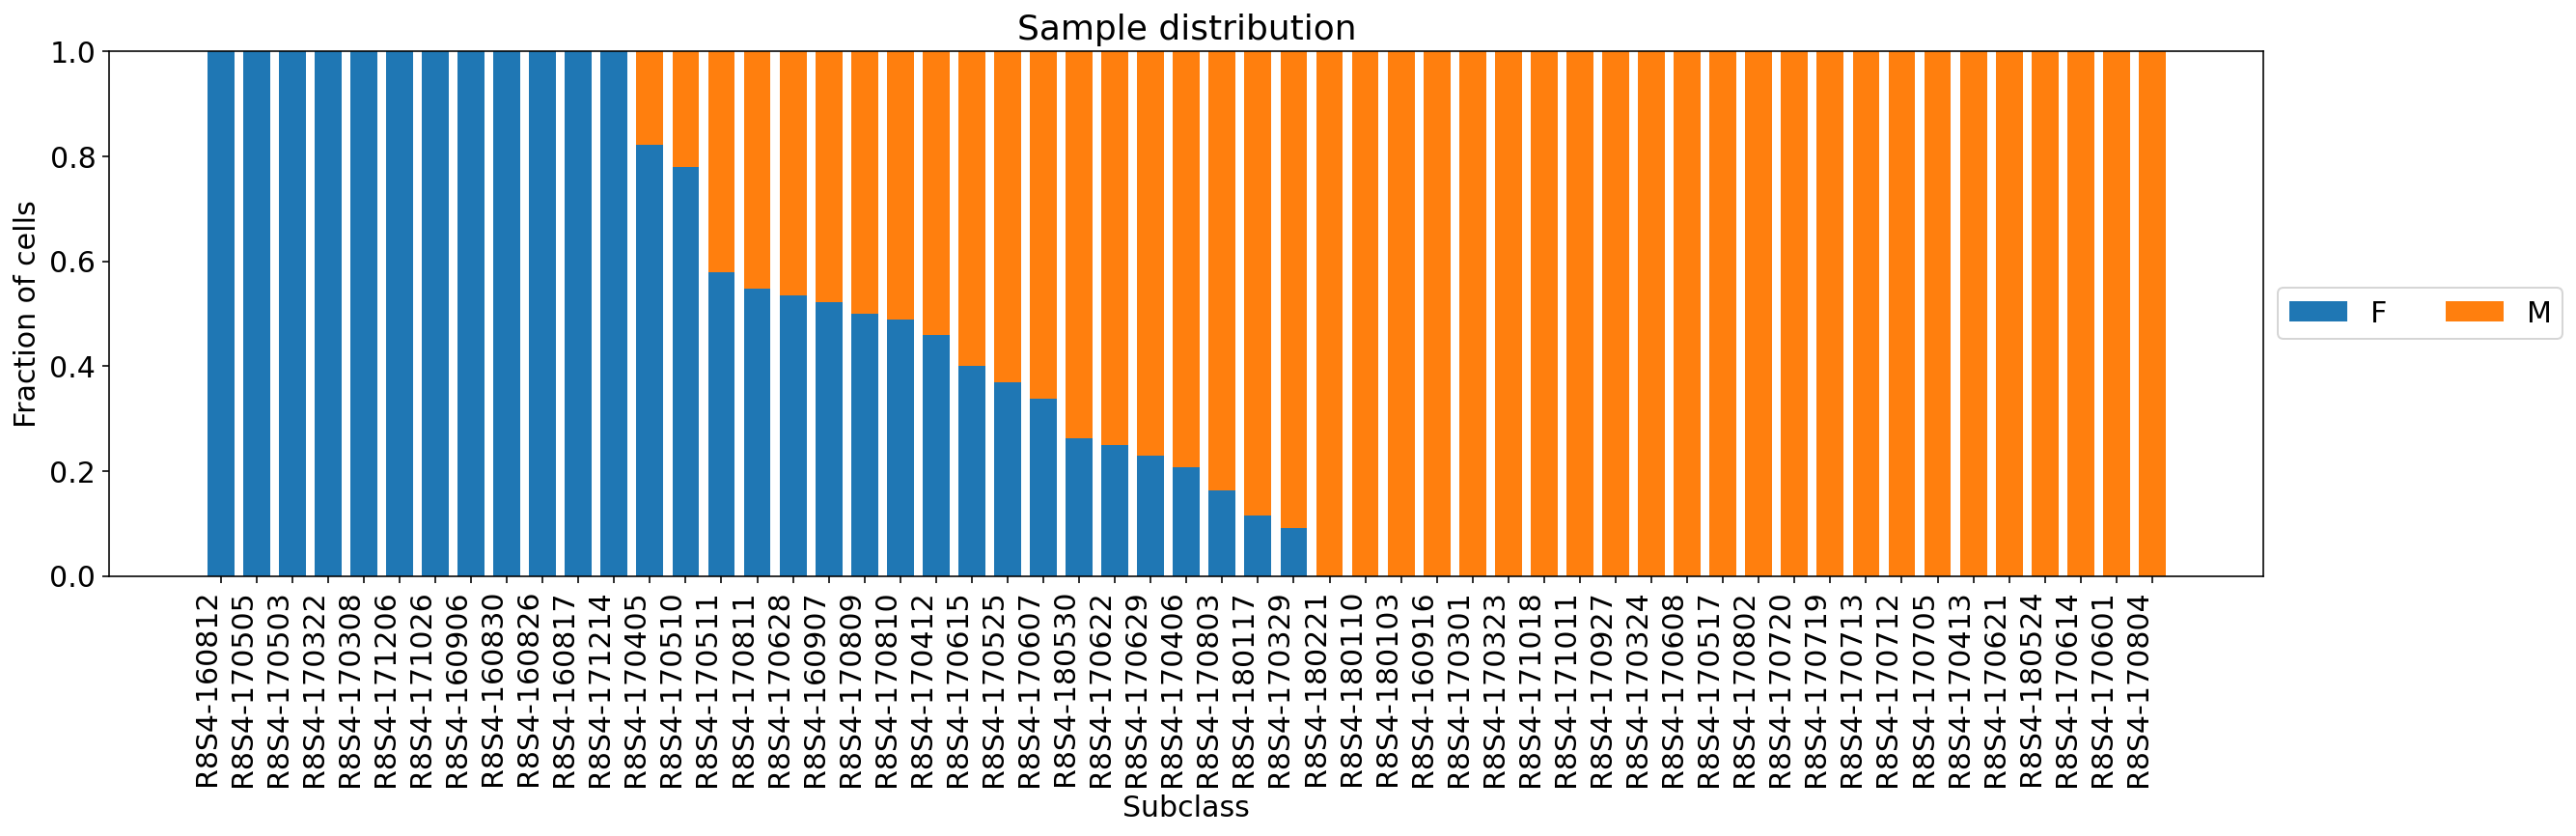

In [173]:
fig, ax = plt.subplots(figsize=(20,5))


width = 0.75

cs = data[0]
ax.bar(labels, cs, width, label=f"{categories[0]}")


for idx, d in enumerate(data[1:], 1):
    ax.bar(labels, d, width, bottom=cs, label=f"{categories[idx]}")
    cs = cs + d

ax.set_xticklabels(labels, rotation = 90, ha="right")
handles, labels = ax.get_legend_handles_labels()
ax.legend(flip(handles, 4), flip(labels, 4), ncol=4, bbox_to_anchor=(1, 0.5), loc="center left", markerscale=3)

ax.set(**{
    "title": "Sample distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Subclass"
})

#plt.savefig(trackfig("../../figures/subclass_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

In [174]:
df = (isoform.obs.groupby("subclass_label")["batch"].value_counts()/isoform.obs.groupby("subclass_label")["batch"].count()).unstack().fillna(0)

In [175]:
labels = df.index.values
categories = df.columns.values
data = df.values.T.copy()

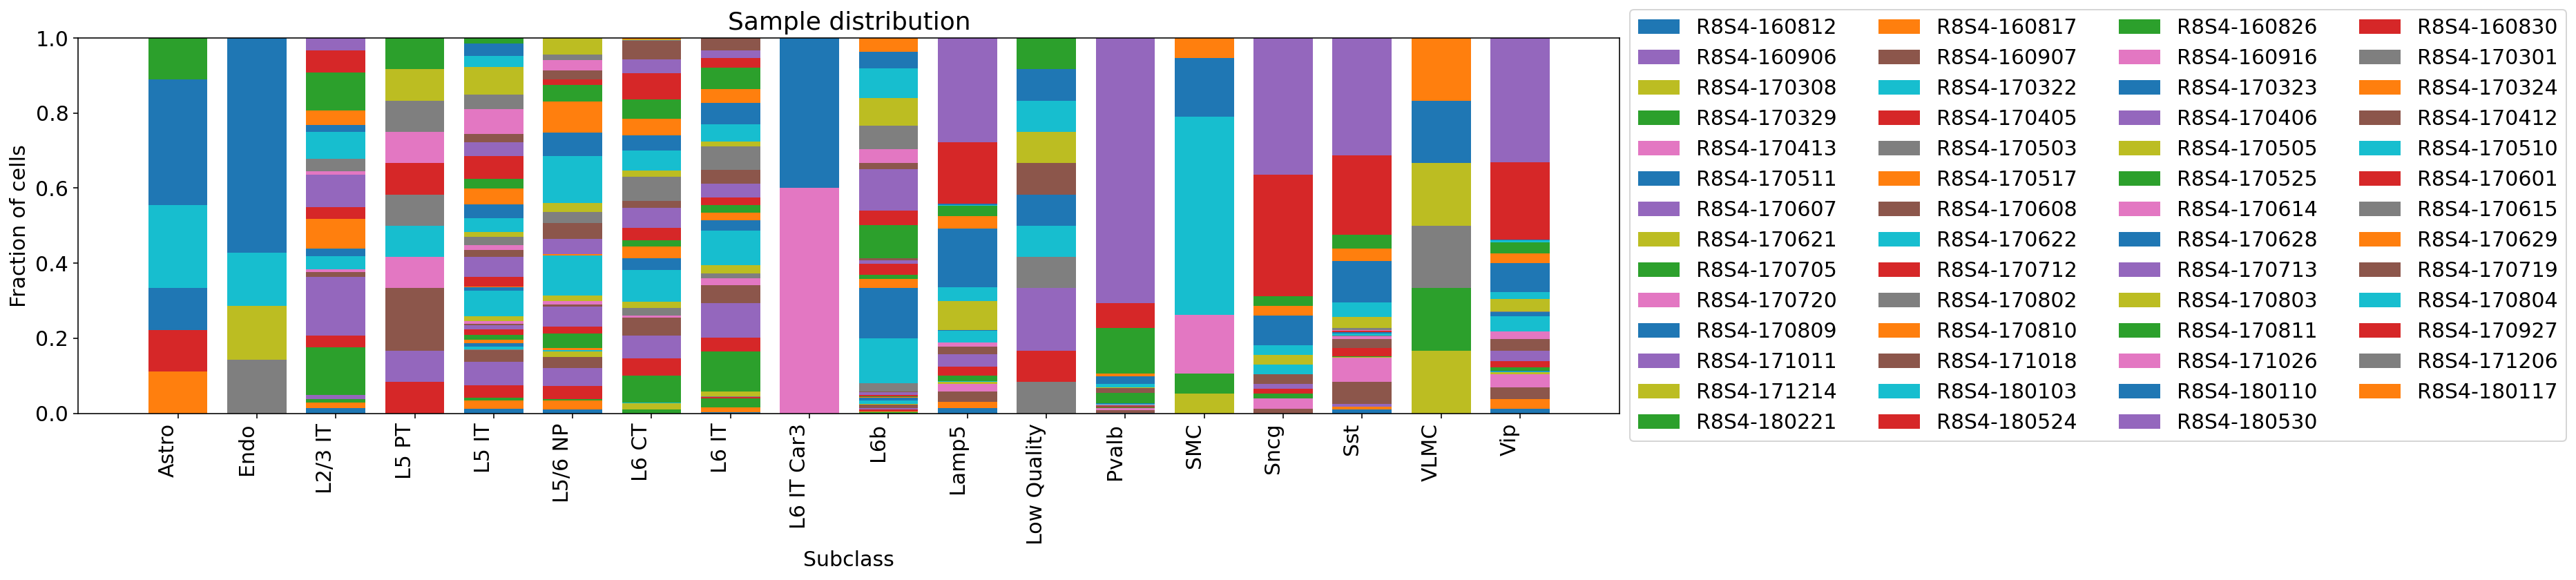

In [176]:
fig, ax = plt.subplots(figsize=(20,5))


width = 0.75

cs = data[0]
ax.bar(labels, cs, width, label=f"{categories[0]}")


for idx, d in enumerate(data[1:], 1):
    ax.bar(labels, d, width, bottom=cs, label=f"{categories[idx]}")
    cs = cs + d

ax.set_xticklabels(labels, rotation = 90, ha="right")
handles, labels = ax.get_legend_handles_labels()
ax.legend(flip(handles, 4), flip(labels, 4), ncol=4, bbox_to_anchor=(1, 0.5), loc="center left", markerscale=3)

ax.set(**{
    "title": "Sample distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Subclass"
})

#plt.savefig(trackfig("../../figures/subclass_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

In [153]:
md["Region"].unique()

array(['MOp'], dtype=object)

In [163]:
md["full_genotype"].value_counts()

Slc17a7-IRES2-Cre/wt;Ai14(RCL-tdT)/wt               1797
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                1410
Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                 924
Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt                 522
Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                   501
Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                   340
Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                   291
Ctgf-T2A-dgCre/wt;Snap25-LSL-F2A-GFP/wt              236
Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                        190
Pvalb-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                 64
Pvalb-T2A-CreERT2/wt;Ai139(TIT2L-GFP-ICL-TPT)/wt      24
Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                     1
Name: full_genotype, dtype: int64

In [146]:
np.sort(md.columns).tolist()

['CPM.16',
 'CPM.32',
 'CPM.4',
 'CPM.64',
 'CPM.8',
 'Class',
 'ERCCLimit',
 'Exclude.STAR',
 'Eye_Cond',
 'FACS.Date',
 'FACS_gate',
 'FPKM.16',
 'FPKM.32',
 'FPKM.4',
 'FPKM.64',
 'FPKM.8',
 'Fill.Date',
 'Genes.Detected',
 'Genes.Detected.CPM',
 'Genes.With.CPM',
 'Genes.With.FPKM',
 'Injection_type',
 'MultiPlex',
 'NewBatch',
 'Nextera.Index.Lot',
 'NexteraLot',
 'Pipette_Filter_size',
 'Region',
 'S4.Lot',
 'Seq_Amp',
 'Trehalose_conc',
 'Type',
 'Vendor',
 'Well.Column',
 'Well.Row',
 'alignment_date',
 'amp_date',
 'amplified_quantity_ng',
 'ar_id',
 'avg_size_bp',
 'batch',
 'batch_vendor_name',
 'cell_id',
 'cell_name',
 'cell_prep_type',
 'complexity_aatt',
 'complexity_acgt',
 'complexity_agct',
 'complexity_at',
 'complexity_catg',
 'complexity_ccgg',
 'complexity_cg',
 'complexity_gatc',
 'complexity_gc',
 'complexity_ta',
 'control',
 'cre_line',
 'exp_cluster_density_thousands_per_mm2',
 'exp_component_vendor_name',
 'experiment_component_failed',
 'external_donor_name

In [9]:
df = (isoform.obs.groupby("subclass_label")["sex"].value_counts()/isoform.obs.groupby("subclass_label")["sex"].count()).unstack().fillna(0)

df = df.sort_values("M", ascending=False)

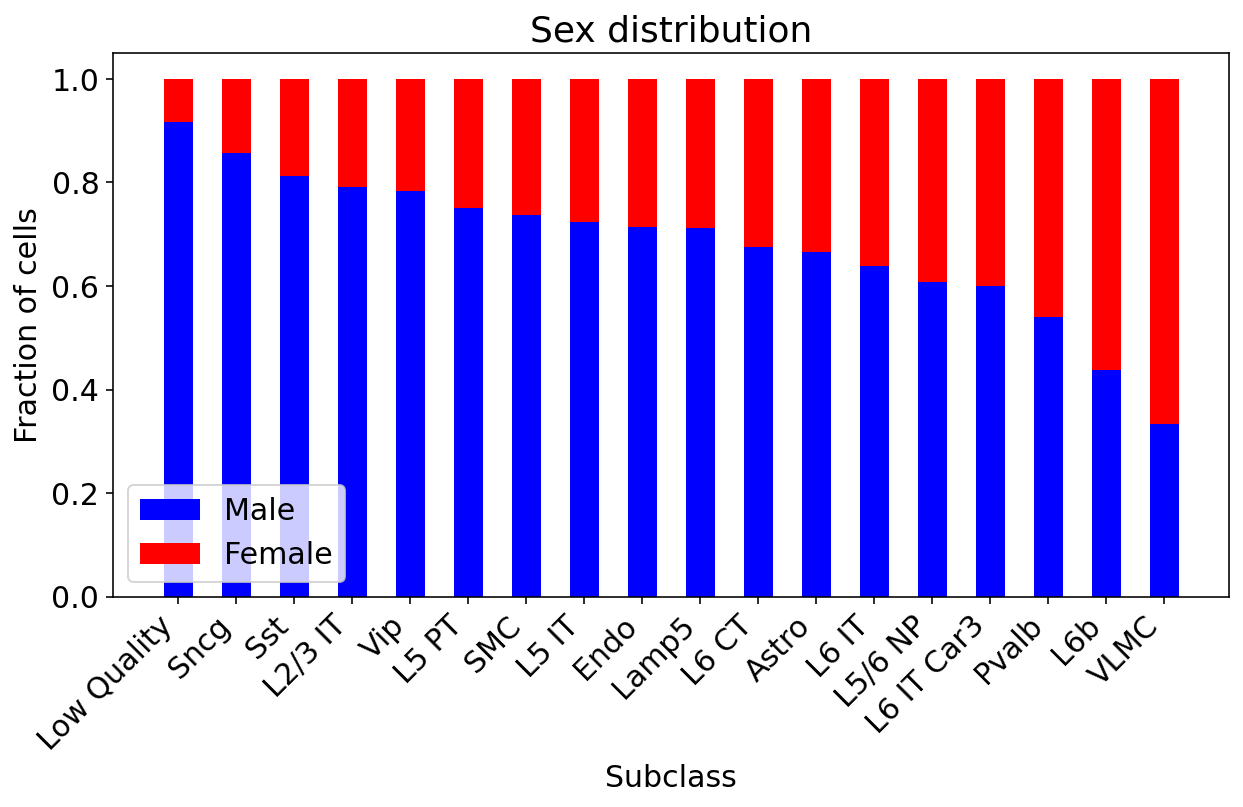

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

labels = df.index.values
width = 0.5

ax.bar(labels, df["M"].values, width, color="blue", label="Male")
ax.bar(labels, df["F"].values, width, bottom=df["M"].values, color="red", label="Female")

ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend(loc="lower left")

ax.set(**{
    "title": "Sex distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Subclass"
})

#plt.savefig(trackfig("../../figures/subclass_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

In [11]:
df = (isoform.obs.groupby("cluster_label")["sex"].value_counts()/isoform.obs.groupby("cluster_label")["sex"].count()).unstack().fillna(0)

df = df.sort_values("M", ascending=False)

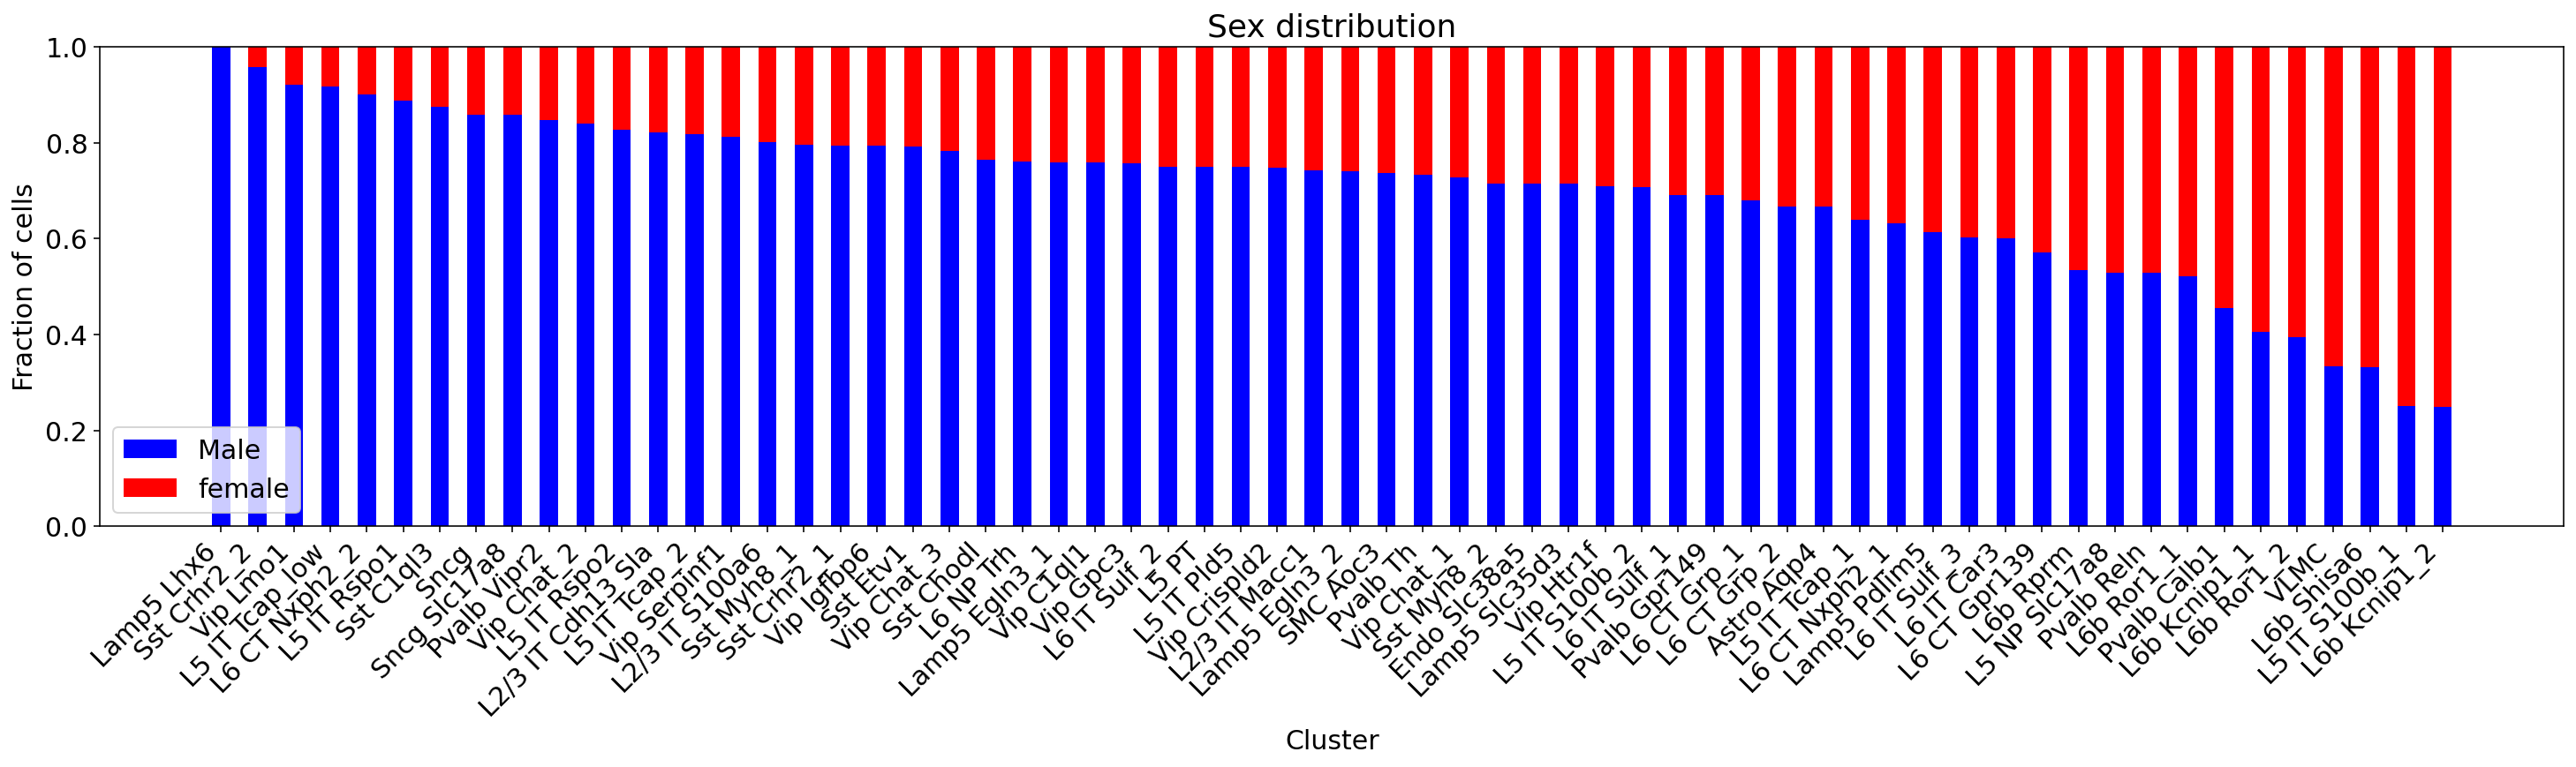

In [12]:
fig, ax = plt.subplots(figsize=(25,5))

labels = df.index.values
width = 0.5

ax.bar(labels, df["M"].values, width, color="blue", label="Male")
ax.bar(labels, df["F"].values, width, bottom=df["M"].values, color="red", label="female")

ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend(loc="lower left")

ax.set(**{
    "title": "Sex distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Cluster"
})

#plt.savefig(trackfig("../../figures/cluster_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

# Comparable fractions

## Subclass

In [76]:
df = (isoform.obs.groupby("subclass_label")["sex"].value_counts()/isoform.obs.groupby("subclass_label")["sex"].count()).unstack().fillna(0)

df = df.sort_values("M", ascending=False)

In [77]:
fr_m, fr_f = isoform.obs["sex"].value_counts()/isoform.obs["sex"].value_counts().sum()

df["adj_F"] = df["F"].apply(lambda x: x/fr_f)
df["adj_M"] = df["M"].apply(lambda x: x/fr_m)

df["norm_F"] = df["adj_F"]/(df["adj_F"] + df["adj_M"])
df["norm_M"] = df["adj_M"]/(df["adj_F"] + df["adj_M"])

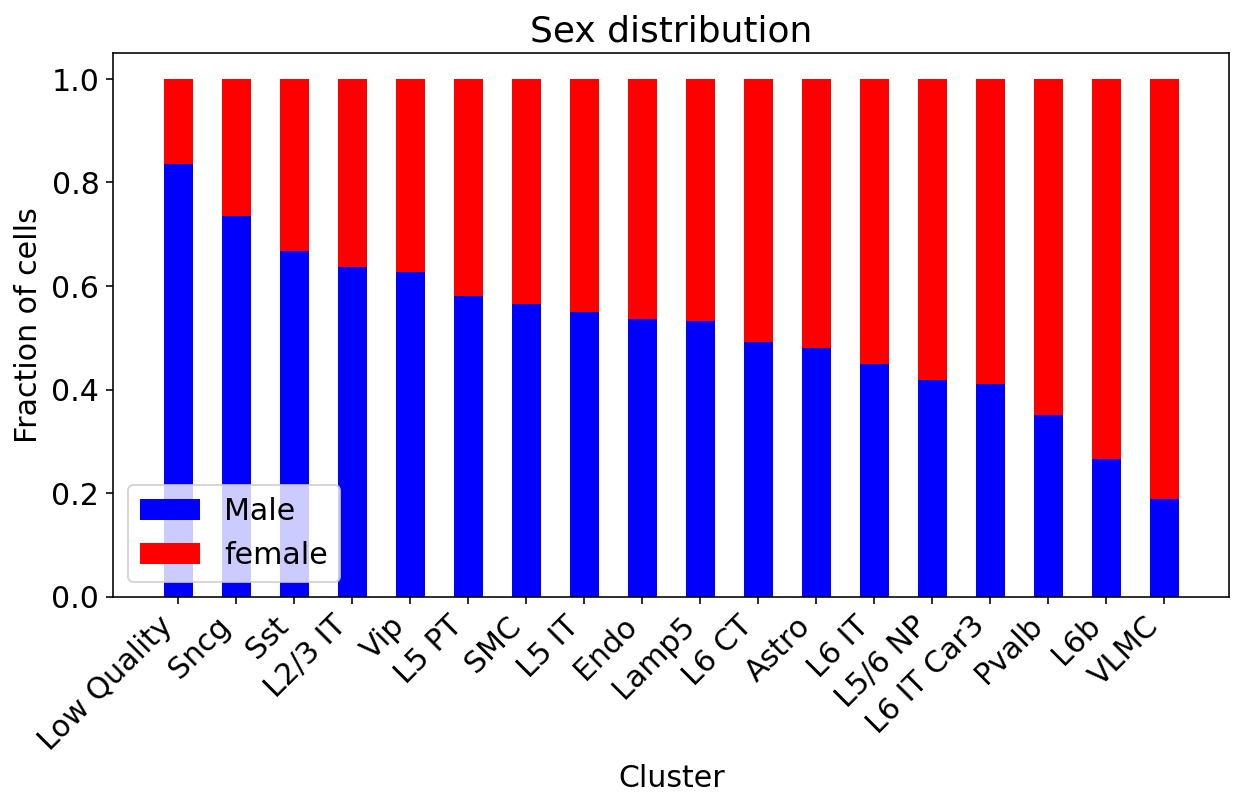

In [78]:
fig, ax = plt.subplots(figsize=(10,5))

labels = df.index.values
width = 0.5

ax.bar(labels, df["norm_M"].values, width, color="blue", label="Male")
ax.bar(labels, df["norm_F"].values, width, bottom=df["norm_M"].values, color="red", label="female")

ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend(loc="lower left")

ax.set(**{
    "title": "Sex distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Cluster"
})

#plt.savefig(trackfig("../../figures/cluster_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

In [79]:
df["n"] = df.index.map(isoform.obs.subclass_label.value_counts())

In [80]:
df.to_csv("../../data/notebook/revision/smartseq_subclass_sex_ratio.csv")

## Cluster

In [52]:
df = (isoform.obs.groupby("cluster_label")["sex"].value_counts()/isoform.obs.groupby("cluster_label")["sex"].count()).unstack().fillna(0)

df = df.sort_values("M", ascending=False)

In [53]:
fr_m, fr_f = isoform.obs["sex"].value_counts()/isoform.obs["sex"].value_counts().sum()

df["adj_F"] = df["F"].apply(lambda x: x/fr_f)
df["adj_M"] = df["M"].apply(lambda x: x/fr_m)

df["norm_F"] = df["adj_F"]/(df["adj_F"] + df["adj_M"])
df["norm_M"] = df["adj_M"]/(df["adj_F"] + df["adj_M"])

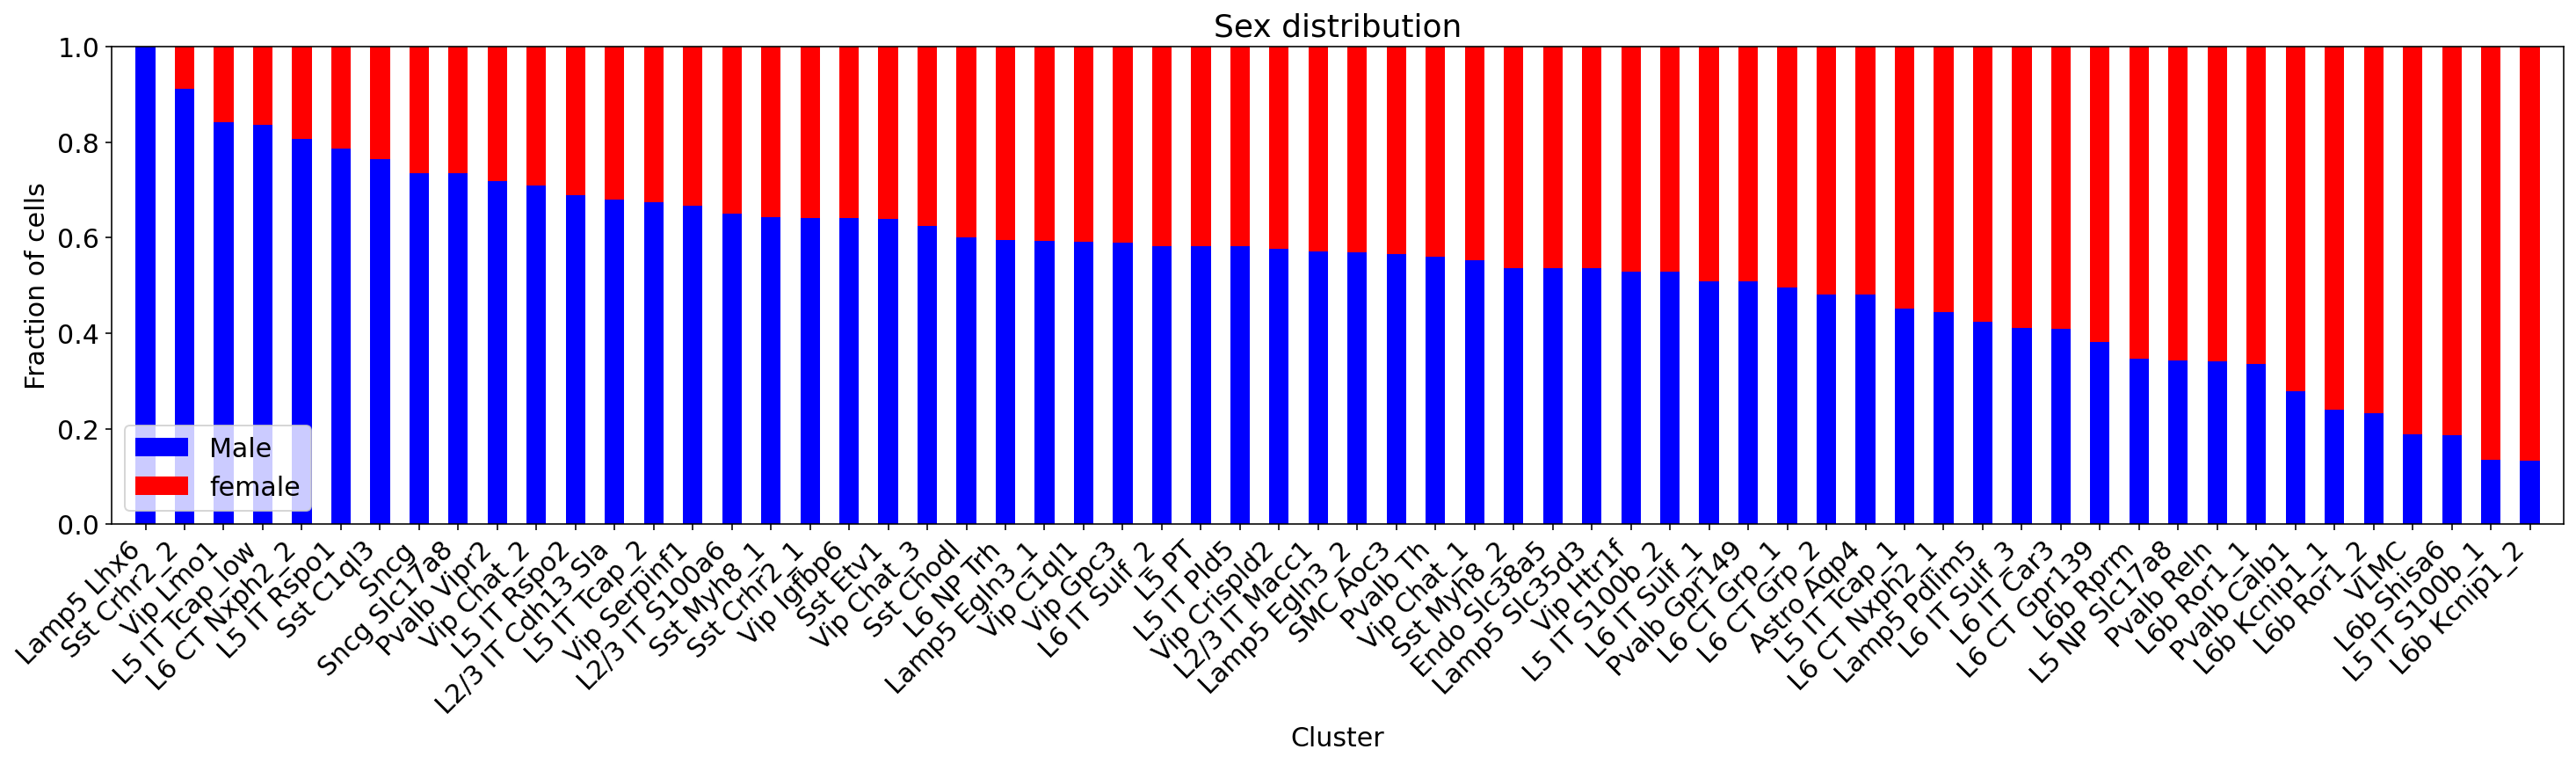

In [59]:
fig, ax = plt.subplots(figsize=(25,5))

labels = df.index.values
width = 0.5

ax.bar(labels, df["norm_M"].values, width, color="blue", label="Male")
ax.bar(labels, df["norm_F"].values, width, bottom=df["norm_M"].values, color="red", label="female")

ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend(loc="lower left")

ax.set(**{
    "title": "Sex distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Cluster"
})
plt.margins(0.01)

plt.savefig(trackfig("../../figures/smartseq_cluster_sex_distribution.png", TRACKFIG, NB), dpi=300, bbox_inches="tight")

fig.show()

In [73]:
df = pd.DataFrame(isoform.obs.subclass_label.value_counts()/isoform.shape[0])

df = df.rename(columns={"subclass_label":"fraction"})

df["n"] = df.index.map(isoform.obs.subclass_label.value_counts())

In [74]:
df

,fraction,n
L5 IT,0.253409,1561
L6 CT,0.146753,904
Vip,0.098539,607
L6b,0.092532,570
Pvalb,0.084578,521
L2/3 IT,0.078247,482
Sst,0.065909,406
L6 IT,0.064123,395
Lamp5,0.058442,360
L5/6 NP,0.033604,207


In [75]:
df.to_csv("../../data/notebook/revision/smartseq_subclass_value_counts.csv")